# Chapter 18. Reinforcement Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import tensorflow.keras as keras
import gym

%matplotlib inline
np.random.seed(0)
sns.set_style('whitegrid')

## Learning to optimize rewards

To set the stage: in reinforcement learning, a software *agent* makes *observations* and takes *actions* within an *environment*, and in return it receives *rewards*.
Its objective is to learn to act in a way that will maximize its expected rewards over time.

### Policy search

The algorithm a software agent uses to determine its action is called its *policy*.
It can be any algorithm, including a neural network, and needs not be deterministic.
The parameters of the policy that can be learned or tweaked are the *policy parameters*.
The *policy search* is the method (e.g. brute force) used to identify good values in the *policy space* for the policy parameters.

*Genetic algorithms* are a popular method for exploring the policy space.
This algorithm involves creating 100 policies and trying them all.
The 80 worst policies are "killed" while the rest "reproduce" 4 offspring each, introducing some random variation in each offspring.
This method continues until a sufficiently good model is created.

Alternatively, an optimization technique can be used to tweak the parameters and follow the gradient of the results.
This is called *policy search* and will be discussed more thoroughly later in the chapter.

## Introduction to OpenAI Gym

[OpenAI Gym](https://gym.openai.com) is a toolkit providing a variety of simulated environments including board games, Atari games, 2D and 2D physical simulations, and more for training RL algorithms.

Here is a breif example of the ["cart-pole" problem](https://gym.openai.com/envs/CartPole-v1/).
An environment is made with `gym.make()` and initialized using `env.reset()`, which also returns the first data point.
This returns a 1D vector with 4 values: the cart's horizontal position, velocity, the angle of the pole, and its angular velocity.

In [2]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.03100318, -0.01310485, -0.00181168, -0.00497128])

The environment can be rendered using its `render()` method.

In [3]:
env.render()

# close the window
env.close()

<img src="assets/ch18/images/cart-pole-firstposition.png" width=500 >

We can ask the environment what the possible actions are, too.
For this problem, there are two options: 0 = left, 1 = right.

In [4]:
env.action_space

Discrete(2)

Since the pole is slightly learning to the left, we will move the cart to the left using the `step()` method of the environment.
This method returns four values:

* `obs`: The new observation to act on.
* `reward`: In this game, the reward is always 1 because the point is to keep the pole up for as long as possible.
* `done`: This value will be true when the episode is over; for this game that means the pole tilts too much, the cart goes off screen, or there have been 200 steps, where fulfilling the last condition means the algorithm has won. An environment must be reset when the episode has finished.
* `info`: An environment-specific dictionary to provide extra information.

Finally, it is good practice to call the `close()` method on an environment to free the resources it is taking.

In [5]:
action = 0
obs, reward, done, info = env.step(action)
obs

array([-0.03126528, -0.20820077, -0.0019111 ,  0.28713949])

In [6]:
reward

1.0

In [7]:
done

False

In [8]:
info

{}

In [9]:
env.close()

The following code would generate a demonstration video of the cart-pole problem.

```python
import gym
env = gym.make('CartPole-v0')
env.reset()
for _ in range(1000):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()
```

As an example, we will hardcode a simple policy: accelerate left when the pole is leaning left and accelerate right when the pole is leaning right.

In [10]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [11]:
totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

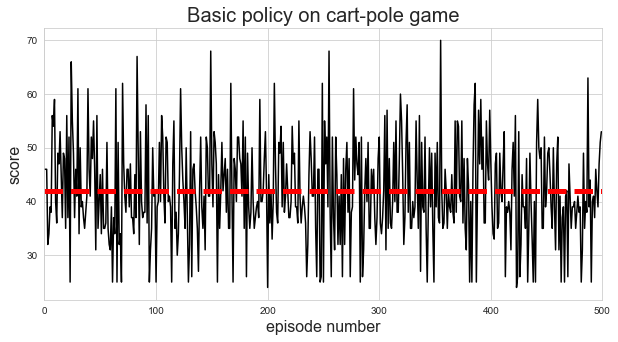

In [12]:
avg_score = np.mean(totals)

fig = plt.figure(figsize=(10, 5))
plt.plot(totals, 'k-')
plt.plot([0, len(totals)], [avg_score, avg_score], 'r--', linewidth=5)
plt.title("Basic policy on cart-pole game", fontsize=20)
plt.xlabel('episode number', fontsize=16)
plt.ylabel('score', fontsize=16)
plt.xlim(0, len(totals))
plt.show()

In [13]:
np.mean(totals), np.median(totals), np.std(totals), np.min(totals), np.max(totals)

(42.02, 41.0, 9.141094026428128, 24.0, 70.0)

## Neural network policies

We will make a single nerual network to play the cart-pole problem.
It will take the four observations as input and output a single probability for left vs. right.
We will then take this probability as the weight for sampling left or right.

In [14]:
n_inputs = 4

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

One difficulty with training this model is telling it out each action affected the game, especially since the action won't necessarily have an immediate impact.
Thus, it is common to evaluate an action's *return*, a weighted sum of all the rewards that follow.
The *discount factor* $\gamma$ is multiplied to the rewards following an action, leading to exponential decay of the effect of future rewards on the action's return.
Further, to help the good actions stand out (called the *action advantage*), we can run the simulation multiple times and normalize the rewards.

## Policy gradients

Here is one variant of a PG algorithm from *REINFORCE algorithms* used to optimize the parameters of a policy (the neural network, in this case):

1. Let the NN play the game several times, computing the gradients that would make the chosen action even more likely (would "reinforce" action) for each round.
2. Compute each action's advantage (as described above).
3. Weight the computed gradients by the advantage to reinforce the good actions and reduce the likelihood of the bad actions.
4. Compute the mean of the resulting gradient vectors and use it to perform a gradient descent step.

We can now implement this algorithm to train the neural network to balance the pole.

First, we make a function to play one step of the cart-pole problem.
Here is how the function works:

1. In the `GradientTape` block, the model is provided a single observation and outputs the probability of moving the car left.
2. The actual decision to go left is made from a random distribution by sampling a uniform distribution and seeing if the output probability was smaller.
3. Then, the action to take is decided as `1 - action` so that the value will be 0 if the model wants to go left, and 1 if the model wants to go right.
4. The loss is calculated as the difference between the output probability of going left and the actual action, taking the chosen action as correct (for now).
5. The tape is used to calculate the gradient of the loss with regard to the model's trainable variables.
6. Finally, the selected action is played in the environment, and the output and the gradient are returned.

In [15]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.0]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

The next function will use the `play_one_step()` function to play multiple episodes, returning the rewards and gradients for each episode and step.
It returns a list of reward lists: one reward list per episode containing one reward per step.
It returns a list of gradient lists: one gradient list per episode, each containing one tuple of gradients per step, the tuples containing one gradient tensor per trainable variable.

At the end of this section, the author recommended using prior knowledge to help the model.
Thus, I used the angle of the pole to reduce the reward as the angle increases in either direction.

In [16]:
def adjust_reward(reward, obs, max_subtraction=0.7):
    return reward - tf.minimum(tf.abs(obs[2]), max_subtraction)

In [17]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            reward = adjust_reward(reward, obs)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

The algorithm will use the `play_multiple_episodes()` function to play the game several time, then discount and normalize the rewards to be used for the reinforcement weights.

We can create a `discount_rewards()` function to compute the sum of future discount rewards at each step.

In [18]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

We can also create a function to normalize the discounted rewards across many episodes.

In [19]:
def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()

    normalized_rewards = [(discounted_rewards - reward_mean) / reward_std
                          for discounted_rewards in all_discounted_rewards]
    return normalized_rewards

Here is a quick test to make sure it works.

In [20]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [21]:
discount_and_normalize_rewards(
    [[10, 0, -50], [10, 20]],
    discount_factor=0.8
)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

Finally, we can define some hyperparameters for the model.

In [22]:
n_iterations = 3 # 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

And we need an optimizer and loss function.

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

Finally, we can create the environment.

In [24]:
env = gym.make("CartPole-v1")

Now we can build the training loop.
Here is how it works:

1. For each training iteration, the loop calls `play_multiple_episodes()` to play the game 10 times and return all of the rewards and gradients for each episode and step.
2. The `discount_and_normalize_rewards()` compute each actions normalized advantage.
3. For each trainable variable, the weighted mean of the gradients over all episodes and steps was calculated and weighted by `final_reward`.
4. Finally, the mean gradients were applied using the optimizer.

In [25]:
for iteration in range(n_iterations):
    print(f"iteration {iteration}")
    all_rewards, all_grads = play_multiple_episodes(env,
                                                    n_episodes_per_update,
                                                    n_max_steps,
                                                    model,
                                                    loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)

    all_mean_grads = []
    for var_idx in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_idx][step][var_idx]
             for episode_idx, final_rewards in enumerate(all_final_rewards)
             for step, final_reward in enumerate(final_rewards)],
            axis=0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

iteration 0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

iteration 1
iteration 2


In [26]:
if True:
    obs = env.reset()
    for _ in range(300):
        env.render()

        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        obs, reward, done, info = env.step(int(action[0, 0].numpy()))
        
    env.close()

/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


I trained the model on 200 iteration on the HMS computing cluster.
The results of that model are shown below.

In [27]:
o2model = tf.keras.models.load_model(
    "assets/ch18/o2-trained-models/trained-cart-pole.tfmodel"
)

In [28]:
if False:
    obs = env.reset()
    for _ in range(500):
        env.render()

        left_proba = o2model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        obs, reward, done, info = env.step(int(action[0, 0].numpy()))

        if done:
            break

    env.close()

<img src="assets/ch18/images/cart-pole-neural-network.gif" width=500 >

Unfortunately, the approach we used here does not scale well to larger and more complex tasks.
It is highly *sample inefficient* meaning that it requires more time to start making meaningful improvement.
This is primarily due to the fact that it must run multiple episodes to estimate the advantage of each action.

To help alleviate these issues we will learn about other optimization algorithms.
This time where the agent learns to estimate the expected return for each state or action in a state, then use that knowledge to make decisions.
To understand these algorithms, we must first understand *Markov decision processes*.

## Markov decision processes

A *Markov chain* is a process with a fixed number of states and randomly evolves from one to another at each step.
The probability for it to evolve from a state $s$ to $s'$ is fixed and depends only on the pair, not the past states (this is why we say it has no memory).
A *Markov decision process* (MDP) is similar, except that at each step, an agent can choose one of several possible actions, and the actions have transition probabilities to other steps.
In addition, some transitions return a reward (positive or negative).
The agent's goal is to find a policy that maximizes the reward over time.

The *optimal state value* of any state $s$, $V^*(s)$, is the sum of all discounted future rewards the agent can expect on average when it reaches a state $s$, assuming it acts optimally.
The *Bellman Optimality Equation* can calculate this value.

$V^*(s) = \max_a \sum_s T(s, a, s') [R(s, a, s') + \gamma \cdot V^*(s')] \quad$ for all $s$

where:

* $T(s, a, s')$ is the transition probability from state $s$ to $s'$ given the agent chose action $a$
* $R(s, a, s')$ is the reward that the agent receives when it goes from state $s$ to $s'$ given the agent chose action $a$
* $\gamma$ is the discount factor

The *Value Iteration algorithm* can be used to estimate the optimal state value for every possible state (initializing the values at 0).

$V_{k+1}(s) \leftarrow \max_{a} \sum_{s'} T(s, a, s') [R(s, a, s') + \gamma \cdot V_k(s')] \quad$ for all $s$

where $V_k(s)$ is the estimate value of state $s$ at the $k^{th}$ iteration of the algorithm.
This recursive algorithm produces the optimal state values to help evaluate a policy, but it does not provide the optimal policy for an agent.
instead, the optimal *state-action values*, generally called *Quality Values* (Q-Values), can be estimated.
The Q-Value of a state-action pair $(s, a)$, $Q^*(s, a)$ is the sum of discounted future rewards the agent can expect on average after it reaches state $s$ and chooses action $a$, but before it sees the outcome of the action.
The *Q-Value Iteration* algorithm can be used to estimate the Q-Values.

$Q_{k+1}(s,a) \leftarrow \sum_{s'} T(s,a,s') [R(s,a,s') + \gamma \cdot \max_{a'} Q_k(s'a')] \quad$ for all $(s',a)$

Once the optimal Q-Values have been found, defining the optimal policy, denoted $\pi^*(s)$, is trival: when the agent is in state $s$, it should choose the action with the highest Q-Value

$
\DeclareMathOperator*{\argmax}{argmax}
\pi^*(s) = \argmax_a Q^*(s, a)
$

(The author demonstrates how to implement this algorithm in Python based on an example in the book.)

## Temporal Difference (TD) Learning